# 1. one-way ANOVA
- model: y ~ x1 (**y is explained by x1 only**)
- reference
    - https://partrita.github.io/posts/ANOVA-python/

In [181]:
url = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_altman/altman_910.txt'
data = pd.read_csv(url, error_bad_lines=False)
data.columns = ['value', 'group']
print(data.head())

   value  group
0    251      1
1    275      1
2    291      1
3    347      1
4    354      1


- 세 집단 간의 평균차이는 유의미한가?(모집단의 평균이 다른가?)

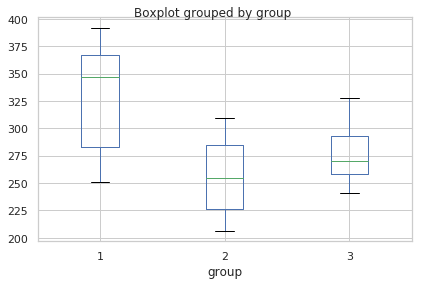

In [109]:
ax = data.boxplot(by='group', column='value', return_type='axes')
plt.title('')
plt.tight_layout()
plt.show()

## 1) 집단간 분산 vs 집단내 분산

In [135]:
c = data['group'] == 1
group1 = data[c].value
c = data['group'] == 2
group2 = data[c].value
c = data['group'] == 3
group3 = data[c].value

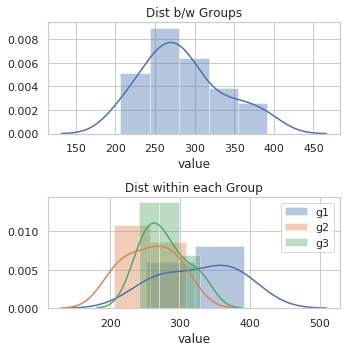

In [64]:
plt.figure(figsize=(5, 5))
plt.subplot(211)
sns.distplot(data.value)
plt.title('Dist b/w Groups')

plt.subplot(212)
sns.distplot(group1, label='g1')
sns.distplot(group2, label='g2')
sns.distplot(group3, label='g3')
plt.title('Dist within each Group')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
# 전체 집단 분산
data.std()[0]

51.73807661122098

In [182]:
# 집단 내 분산
print(data.groupby('group').agg(['std', 'mean']))

           value            
             std        mean
group                       
1      54.679151  327.142857
2      37.121797  256.444444
3      33.756481  278.000000


## 2.1) ANOVA(`scipy`)
- group1, 2, 3 일부 모집단의 평균은 다름
- 그런데 어느 그룹간 다른지는 모름 -> Dunnett test

In [183]:
f_stat, pval = sp.stats.f_oneway(group1, group2, group3)
f_stat, pval

(5.3739149211015285, 0.01479132076930809)

## 2.2) ANOVA(`statsmodels`)

In [184]:
f = 'value ~ C(group)'
mod = sm.OLS.from_formula(f, data)
r = mod.fit()
print(sm.stats.anova_lm(r))

            df        sum_sq       mean_sq         F    PR(>F)
C(group)   2.0  20015.492063  10007.746032  5.373915  0.014791
Residual  18.0  33521.079365   1862.282187       NaN       NaN


## 2.3) Tukey's range test(다중비교)
- 어떤 집단 간 평균 차이가 유의미 한가: 그룹1, 2
- Dunnett test도 가능
- reference 
    - http://cleverowl.uk/2015/07/01/using-one-way-anova-and-tukeys-test-to-compare-data-sets/
    - https://support.minitab.com/ko-kr/minitab/18/help-and-how-to/modeling-statistics/anova/supporting-topics/multiple-comparisons/using-multiple-comparisons-to-assess-differences-in-means/

In [185]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(data['value'], data['group'])
result = mc.tukeyhsd(alpha=0.05)
print(result)
print(mc.groupsunique)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff   lower    upper   reject
------------------------------------------------
  1      2    -70.6984 -126.1814 -15.2154  True 
  1      3    -49.1429 -113.6083 15.3226  False 
  2      3    21.5556   -39.8529  82.964  False 
------------------------------------------------
[1 2 3]


## 2.4) T-test
- 위 결과와 동일: group1, 2의 모평균이 다름

In [91]:
sp.stats.ttest_ind(group1, group3), sp.stats.ttest_ind(group2, group3), sp.stats.ttest_ind(group1, group2)

(Ttest_indResult(statistic=1.7694686658197478, pvalue=0.10724485227970977),
 Ttest_indResult(statistic=-1.0724508202985763, pvalue=0.30461196197608215),
 Ttest_indResult(statistic=3.084335391983187, pvalue=0.008079886184693645))

---

# 2. two-way ANOVA by F-statistic
- model: y ~ x1, x2(**y is explained by x1, x2( and interaction)**)

## 1) Sample1
- 검사자observer에 따라 태아fetus의 머리크기head-size에 차이가 있는가?
- $H0_1$: 검사자x1 간 머리크기y 차이는 없다
- $H0_2$: 태아x2 간 머리크y 차이 없다
- reference: https://partrita.github.io/posts/ANOVA-python/

In [186]:
import urllib
file = 'altman_12_6.txt'
base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_altman/'
url = base + file
data = np.genfromtxt(urllib.request.urlopen(url), delimiter=',')
df = pd.DataFrame(data, columns=['head_size', 'fetus', 'observer'])

In [187]:
print(df.groupby(['fetus','observer']).agg(list).unstack())

                   head_size                                          \
observer                 1.0                 2.0                 3.0   
fetus                                                                  
1.0       [14.3, 14.0, 14.8]  [13.6, 13.6, 13.8]  [13.9, 13.7, 13.8]   
2.0       [19.7, 19.9, 19.8]  [19.8, 19.3, 19.8]  [19.5, 19.8, 19.5]   
3.0       [13.0, 12.6, 12.9]  [12.4, 12.8, 12.5]  [12.8, 12.7, 12.5]   

                              
observer                 4.0  
fetus                         
1.0       [13.8, 14.7, 13.9]  
2.0       [19.8, 19.6, 19.8]  
3.0       [13.0, 12.9, 13.8]  


In [151]:
f = 'head_size ~ C(observer) + C(fetus) + C(observer):C(fetus) '
mod = sm.OLS.from_formula(f, df)
res = mod.fit()
print(res.summary2())

                         Results: Ordinary least squares
Model:                     OLS                   Adj. R-squared:          0.992   
Dependent Variable:        head_size             AIC:                     19.1085 
Date:                      2019-03-13 09:28      BIC:                     38.1107 
No. Observations:          36                    Log-Likelihood:          2.4458  
Df Model:                  11                    F-statistic:             386.3   
Df Residuals:              24                    Prob (F-statistic):      3.29e-24
R-squared:                 0.994                 Scale:                   0.076667
----------------------------------------------------------------------------------
                                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------------------
Intercept                          14.3667   0.1599 89.8697 0.0000 14.0367 14.6966
C(observer)[T.2.0]            

In [188]:
print(sm.stats.anova_lm(res))

              df  sum_sq  mean_sq     F    PR(>F)
C(car_type)  2.0  9300.0   4650.0  93.0  0.010638
C(company)   1.0  1350.0   1350.0  27.0  0.035099
Residual     2.0   100.0     50.0   NaN       NaN


---

## 2) Sample2
- 차종x1/보험회사x2에 따라 보험료
- reference: https://rfriend.tistory.com/135

In [189]:
data = {'com_K': [140, 210, 220],
       'com_M': [100, 180, 200],}
test = pd.DataFrame(data, index=list(map(lambda x: 'car_' + x, list('ABC'))))
print(test)

       com_K  com_M
car_A    140    100
car_B    210    180
car_C    220    200


In [190]:
data = {'y':[140, 100, 210, 180, 220, 200], 'car_type':['A', 'A', 'B', 'B', 'C', 'C'], 'company':['K', 'M', 'K', 'M', 'K', 'M']}
test_modified = pd.DataFrame(data)
print(test_modified)

     y car_type company
0  140        A       K
1  100        A       M
2  210        B       K
3  180        B       M
4  220        C       K
5  200        C       M


In [191]:
f = 'y ~ C(car_type) + C(company)'
mod = sm.OLS.from_formula(f, test_modified)
res = mod.fit()
print(res.summary2())

                  Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.977  
Dependent Variable:  y                 AIC:                 41.9077
Date:                2019-03-13 14:34  BIC:                 41.0748
No. Observations:    6                 Log-Likelihood:      -16.954
Df Model:            3                 F-statistic:         71.00  
Df Residuals:        2                 Prob (F-statistic):  0.0139 
R-squared:           0.991             Scale:               50.000 
-------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
-------------------------------------------------------------------
Intercept        135.0000   5.7735 23.3827 0.0018 110.1586 159.8414
C(car_type)[T.B]  75.0000   7.0711 10.6066 0.0088  44.5757 105.4243
C(car_type)[T.C]  90.0000   7.0711 12.7279 0.0061  59.5757 120.4243
C(company)[T.M]  -30.0000   5.7735 -5.1962 0.0351 -54.8414  -5.158

/home/henry/.local/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


In [192]:
print(sm.stats.anova_lm(res))

              df  sum_sq  mean_sq     F    PR(>F)
C(car_type)  2.0  9300.0   4650.0  93.0  0.010638
C(company)   1.0  1350.0   1350.0  27.0  0.035099
Residual     2.0   100.0     50.0   NaN       NaN


In [160]:
# R^2 by ANOVA
(9300 + 1350)/(9300 + 1350 + 100)

0.9906976744186047

---
- 아직 two-way ANOVA에서 regression R^2로 F-statistic 구하는 방법 모르겠음